# Imports

In [2]:
# System
import sys
import os
import math
import copy
# Time
import time
# Date time
import datetime as dt
# PyTorch framework
import torch
from torch import nn
# Work with arrays
import numpy as np
# Work with dataframes
import pandas as pd
# Make figures
import matplotlib.pyplot as plt
import seaborn as sns
# Hyperparameters optimization
import optuna

# Amplitude functions

## Gaussian

In [3]:
class Gaussian(nn.Module):
  """Custom Gaussian amplitude function class"""

  def __init__(self, config, bandwidth=1.0):
    super().__init__()
    self.coordinateSpaceDim = config['coordinate space dimension']
    self.numberOfStates = config['number of states']
    self.device = config['device']

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    forward = torch.ones(
      (
        len(x),
        self.numberOfStates
      ),
      device=self.device
    )
    forward = torch.mul(
      forward.t(),
      torch.exp(-torch.sum(x**2, axis=1) / 2)
    ).t()
    return forward

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = torch.ones(
      (
        len(x),
        self.coordinateSpaceDim,
        self.numberOfStates
      ),
      device=self.device
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      temporalTerm = torch.ones(
        (
          len(x),
          self.numberOfStates
        ),
        device=self.device
      )
      temporalTerm = torch.mul(
        temporalTerm.t(),
        torch.exp(-torch.sum(x**2, axis=1) / 2) * (-2 * x[:, coordinateNumber] / 2),
      ).t()
      gradient[:, coordinateNumber, :] = temporalTerm
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    laplacian = torch.ones(
      (
        len(x),
        self.numberOfStates
      ),
      device=self.device
    )
    laplacian = torch.mul(
      laplacian.t(),
      torch.exp(-torch.sum(x**2, axis=1) / 2)
      * (
        torch.sum((-2 * x / 2) ** 2, axis=1)
        - 2 * torch.sum(torch.ones_like(x) / 2, axis=1)
      )
    ).t()
    return laplacian


# Neural network

In [4]:
class NeuralNetwork(nn.Module):
  """Class for a neural network"""

  def __init__(self, config):
    super().__init__()
    self.coordinateSpaceDim = config['coordinate space dimension']
    self.numberOfStates = config['number of states']
    self.hiddenLayerSize = config['hidden layer size']
    self.device = config['device']
    self.defActivationFunction(config)
    self.numberOfHiddenLayers = config['number of hidden layers']
    self.defAndInitStack(config['std of initial weights'])
    self.stack.to(self.device)

  def defActivationFunction(self, config):
    if config['activation function'] == 'sin':
      self.activationFunction = CustomSin()
    elif config['activation function'] == 'tanh':
      self.activationFunction = CustomTanh()
    else:
      print("INVALID ACTIVATION FUNCTION NAME")
      sys.exit(1)

  def defAndInitStack(self, stdOfInitWeights):
    self.stack = nn.Sequential()
    self.stack.append(
      nn.Linear(
        self.coordinateSpaceDim,
        self.hiddenLayerSize
      )
    )
    self.stack.append(
      self.activationFunction
    )
    for hiddenLayerNumber in range(self.numberOfHiddenLayers-1):
      self.stack.append(
        nn.Linear(
          self.hiddenLayerSize,
          self.hiddenLayerSize
        )
      )
      self.stack.append(
        self.activationFunction
      )
    self.stack.append(
      nn.Linear(
        self.hiddenLayerSize,
        self.numberOfStates
      )
    )
    self.stack.append(
      self.activationFunction
    )
    for stackSliceNumber in range(len(self.stack)):
      if "weight" in dir(self.stack[stackSliceNumber]):
        nn.init.normal_(
          self.stack[stackSliceNumber].weight,
          0,
          stdOfInitWeights
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.stack(x)

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = (
      torch.zeros(
        (
          len(x),
          self.coordinateSpaceDim,
          self.numberOfStates
        ),
        device = self.device
      )
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      firstDerivative = self.activationFunction.firstDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber]
      function = self.stack[0*2+1](self.stack[0*2](x))
      for hiddenLayerNumber in range(1, self.numberOfHiddenLayers + 1):
        firstDerivative = self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        function = self.stack[hiddenLayerNumber * 2 + 1](
          self.stack[hiddenLayerNumber * 2](function)
        )
      gradient[:, coordinateNumber, :] = firstDerivative
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    preresult = torch.ones(
      (
        len(x),
        self.coordinateSpaceDim,
        self.numberOfStates
      ),
      device=self.device
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      firstDerivative = self.activationFunction.firstDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber]
      secondDerivative = self.activationFunction.secondDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber] ** 2
      function = self.stack[0 * 2 + 1](self.stack[0 * 2](x))
      for hiddenLayerNumber in range(1, self.numberOfHiddenLayers + 1):
        secondDerivative = self.activationFunction.secondDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        ) ** 2 \
        + self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
            secondDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        firstDerivative = self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        function = self.stack[hiddenLayerNumber * 2 + 1](
          self.stack[hiddenLayerNumber * 2](function)
        )
      preresult[:, coordinateNumber, :] = secondDerivative
    return torch.sum(preresult, axis=1)

class CustomSin(nn.Module):
    """Custom sin activation function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

    def firstDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return torch.cos(x)

    def secondDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return -torch.sin(x)

class CustomTanh(nn.Module):
    """Custom tanh activation function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.tanh(x)

    def firstDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return 1 / torch.cosh(x) ** 2

    def secondDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return -2 * torch.sinh(x) / torch.cosh(x) ** 3

# Distribution density

In [5]:
def distributionDensity(x: torch.Tensor) -> torch.Tensor:
    bandwidth = 0.2
    res = torch.sum(
        torch.exp(-torch.cdist(x, x, p=2)**2 / 2 / bandwidth**2),
        axis=1
    )
    return (res / res.sum())

# Trial function

In [6]:
class TrialFunction(nn.Module):
  """Trial function class"""

  def __init__(self, config, name: str):
    """Initialize trial function"""
    super().__init__()
    self.name = name
    self.PATH = "../models/" + self.name + ".pt"
    self.defDevice(config)
    self.neuralNetwork = NeuralNetwork(config)
    self.defAmplitudeFunction(config)
    print("Trial function with name "+name+" has been created")

  def defDevice(self, config):
    """Define device"""
    self.device = config['device']

  def defAmplitudeFunction(self, config):
    """Define amplitude function"""
    if config['amplitude function'] == 'gaussian':
      self.amplitudeFunction = Gaussian(config)
    else:
      print("INVALID AMPLITUDE FUNCTION NAME")
      sys.exit(1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    forward = self.neuralNetwork(x) * self.amplitudeFunction(x)
    return forward

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = (
      torch.zeros(
        (
          len(x),
          self.neuralNetwork.coordinateSpaceDim,
          self.neuralNetwork.numberOfStates
        ),
        device = self.device
      )
    )
    theAmplitudeFunction = self.amplitudeFunction(x)
    theAmplitudeFunctionGradient = self.amplitudeFunction.gradient(x)
    theNeuralNetwork = self.neuralNetwork(x)
    theNeuralNetworkGradient = self.neuralNetwork.gradient(x)
    for coordinateNumber in range(self.neuralNetwork.coordinateSpaceDim):
      gradient[:, coordinateNumber, :] = (
        theNeuralNetworkGradient[:, coordinateNumber, :] * theAmplitudeFunction
        + theNeuralNetwork * theAmplitudeFunctionGradient[:, coordinateNumber, :]
      )
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    laplacian = (
      self.neuralNetwork.laplacian(x) * self.amplitudeFunction(x)
      + self.neuralNetwork(x) * self.amplitudeFunction.laplacian(x)
      + 2 * torch.sum(
        self.neuralNetwork.gradient(x) * self.amplitudeFunction.gradient(x),
        axis=1
      )
    )
    return laplacian

  def weightFunction(self, x: torch.Tensor) -> torch.Tensor:
    weightFunction = torch.mean(self.forward(x)**2, axis=1)
    return weightFunction

  def norm(self, x: torch.Tensor, isTrainSample=True) -> torch.Tensor:
    norm = torch.zeros(
      self.neuralNetwork.numberOfStates,
      device=self.device
    )
    forward = self.forward(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    for stateNumber in range(self.neuralNetwork.numberOfStates):
      norm[stateNumber] = torch.mean(
        forward[:, stateNumber]**2 / weightFunction
      )
    return norm

  def spectrum(self, x: torch.Tensor, isTrainSample=True) -> torch.Tensor:
    spectrum = torch.zeros(
      self.neuralNetwork.numberOfStates,
      device=self.device
    )
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    potential = 0.5 * torch.sum(x*x, axis=1)
    for stateNumber in range(self.neuralNetwork.numberOfStates):
      spectrum[stateNumber] = torch.mean(
        forward[:, stateNumber] * (
          -0.5* laplacian[:, stateNumber]
          + potential * forward[:, stateNumber]
        ) / weightFunction
      )
    spectrum = spectrum / self.norm(x, isTrainSample)
    return spectrum

  def totalSqueredResidual(self, x: torch.Tensor, isTrainSample=True) -> torch.Tensor:
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    spectrum = self.spectrum(x, isTrainSample)
    norm = self.norm(x, isTrainSample)
    return sum(
      [
        torch.mean(
          (
            -0.5 * laplacian[:, stateNumber]
            + 0.5 * forward[:, stateNumber] * torch.sum(x**2, axis=1)
            - forward[:, stateNumber] * spectrum[stateNumber]
          )** 2 / weightFunction
        ) / norm[stateNumber]
        for stateNumber in range(self.neuralNetwork.numberOfStates)
      ]
    )

  def squeredResidual(
      self, 
      x: torch.Tensor, 
      isTrainSample=True
  ) -> torch.Tensor:
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    spectrum = self.spectrum(x, isTrainSample)
    norm = self.norm(x, isTrainSample)
    return [
        torch.mean(
          (
            -0.5 * laplacian[:, stateNumber]
            + 0.5 * forward[:, stateNumber] * torch.sum(x**2, axis=1)
            - forward[:, stateNumber] * spectrum[stateNumber]
          )** 2 / weightFunction
        ) / norm[stateNumber]
        for stateNumber in range(self.neuralNetwork.numberOfStates)
      ]

  def totalNormalisationError(
      self, 
      x: torch.Tensor, 
      isTrainSample=True
  ) -> torch.Tensor:
    return torch.sum((self.norm(x, isTrainSample) - torch.tensor(1, device=self.device)) ** 2)

  def totalOrthogonalisationError(
      self, 
      x: torch.Tensor, 
      isTrainSample=True
  ) -> torch.Tensor:
    orthogonError = torch.zeros(
      (
        self.neuralNetwork.numberOfStates,
        self.neuralNetwork.numberOfStates
      ),
      device=self.device
    )
    forward = self.forward(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    norm = self.norm(x, isTrainSample)
    for stateNumber1 in range(1, self.neuralNetwork.numberOfStates):
      for stateNumber2 in range(0, stateNumber1):
        orthogonError[stateNumber1, stateNumber2] = (
          torch.square(
            torch.mean(
              forward[:, stateNumber1]
              * forward[:, stateNumber2]
              / weightFunction
            )
          )
          / norm[stateNumber1]
          / norm[stateNumber2]
        )
    return torch.sum(orthogonError)

# Metropolis sampler

In [7]:
class MetropolisSampler():
  """Class for Metropolis sampler"""

  def __init__(self, config):
    self.epsilon = config['metropolis algorithm parameter']
    self.device = config['device']
    self.sample = self.initialSample(config)

  def initialSample(self, config) -> torch.Tensor:
    return 3 * (
      torch.rand(
        (
          config['sample size'],
          config['coordinate space dimension']
        )
      ) - 0.5
    ).to(self.device)

  def updateSampleBasOnDistrDens(self, __distributionDensity):
    newSample = self.sample + self.epsilon * (
      2 * torch.rand_like(
        self.sample,
        device=self.device
      ) - 1
    )
    critVal = __distributionDensity(newSample) / __distributionDensity(self.sample)
    doesPointMove = (torch.rand(len(self.sample), device=self.device) <= critVal)
    newSample = (
      torch.mul(doesPointMove.int(), newSample.t()).t()
      + torch.mul((1 - doesPointMove.int()), self.sample.t()).t()
    )
    self.sample = newSample

# Footprint plot of wave functions

In [8]:
def footprintPlot(modelConfig, modelName, modelPath, states):

    model = TrialFunction(modelConfig, modelName)
    model.load_state_dict(torch.load(modelPath))
    model.eval()

    COORD_DIM = modelConfig["coordinate space dimension"]
    SQRT_SAMPLE_SIZE = int(math.sqrt(int(modelConfig["sample size"])))
    SAMPLE_SIZE = SQRT_SAMPLE_SIZE ** 2
    L = 3.0

    figs = []

    for state in states:
        print(state)
        fig, axes = plt.subplots(COORD_DIM, COORD_DIM, figsize=(16,16))
        for x1 in range(COORD_DIM):
            for x2 in range(COORD_DIM):
                if x1 == x2:
                    a = torch.linspace(-L,L,SAMPLE_SIZE).cuda()
                    sample = torch.zeros((SAMPLE_SIZE,COORD_DIM)).cuda()
                    sample[:,x1] = a

                    waveFunction = model(sample)[:,state]
                    energy = model.spectrum(sample, False)[state]
                    sqrRes = model.squeredResidual(sample, False)[state]

                    axes[x1,x2].plot(
                        a.cpu().detach().numpy(), 
                        (waveFunction / torch.max(abs(waveFunction))).cpu().detach().numpy()
                    )
                    axes[x1,x2].axhline(y=0, color='k', linestyle='--')
                    axes[x1,x2].set(
                        xlim=(-L,L),
                        ylim=(-1,1),
                        title=fr'energy is {energy:.4f}, sqr. res. is {sqrRes:.2e}'
                    )                    
                    
                if x1 != x2:
                    a = torch.linspace(-L,L,SQRT_SAMPLE_SIZE).cuda()
                                    
                    sample = torch.zeros((SAMPLE_SIZE,COORD_DIM)).cuda()

                    for i1 in range(SQRT_SAMPLE_SIZE):
                        for i2 in range(SQRT_SAMPLE_SIZE):
                            sample[i1*SQRT_SAMPLE_SIZE+i2,x1] = a[i1]
                            sample[i1*SQRT_SAMPLE_SIZE+i2,x2] = a[i2]
    
                    waveFunction = model(sample)[:,state]
                    energy = model.spectrum(sample, False)[state]
                    sqrRes = model.squeredResidual(sample, False)[state]                
                    
                    axes[x1,x2].contourf(
                        a.cpu().detach().numpy(), 
                        a.cpu().detach().numpy(), 
                        (waveFunction / torch.max(abs(waveFunction))).cpu().detach().numpy().reshape(SQRT_SAMPLE_SIZE,SQRT_SAMPLE_SIZE),
                        vmax=1, vmin=-1, levels=19,
                        cmap="PiYG"
                    )
                    axes[x1,x2].set_title(fr'energy is {energy:.4f}, sqr. res. is {sqrRes:.2e}')
                    axes[x1,x2].set_xlim(-L,L)
                    axes[x1,x2].set_ylim(-L,L)
        figs += [fig]
    return figs

# Train model (function)

In [9]:
def trainModel(
    config: dict,
    maxSqrResidual=1e-3,
    trainName="test",
    pathToSaveData="../results/",
    STEP_PERIOD=100
):
    time0 = time.time()
    hist = {
        'time' : list(),
        'tot loss' : list(),
        'sqr res' : list(),
        'norm dev' : list(),
        'in orthog dev' : list(),
    }
    for i in range(config['number of states']):
        hist[f"e{i}"] = list()
    
    modelName = trainName + "_" + str(
        f"{config['coordinate space dimension']}d_"
        +f"{config['hidden layer size']}L_"
        +f"{config['number of hidden layers']}Nh_"
        +time.strftime("%d%b%Y_%H:%M:%S", time.gmtime())
    )

    model = TrialFunction(config, modelName)
    optimizer = torch.optim.AdamW(
            params=list(model.parameters()),
            lr=config['initial learning rate'],
            weight_decay=config['weight decay'],
        )
    
    # if doLoadModel:
    #     model.load_state_dict(torch.load(modelPath))
    #     model.eval()
    #     optimizer.load_state_dict(torch.load(optimizerPath))        

    validStates = []

    lossFnc = nn.L1Loss()
    
    step = 0
    goodSteps = 0
    while goodSteps < 100:
        if step == 0:
            sampler = MetropolisSampler(config)
        else:
            for i in range(10):
                sampler.updateSampleBasOnDistrDens(
                    model.weightFunction
                )
        step += 1
        # Loss
        sample = sampler.sample
        sqrRes = model.totalSqueredResidual(sample)
        normDev = model.totalNormalisationError(sample)
        e = model.spectrum(sample)
        inOrthogDev = model.totalOrthogonalisationError(sample)
        if step == 1:
            eFactor = float(torch.sum(e).detach().item())
        totLoss = lossFnc(
            config['residual term weight'] * sqrRes 
            + config['normalisation term weight'] * normDev
            + config['energy term weight'] * torch.sum(e) / eFactor 
            + config['orthogonalisation term weight'] * inOrthogDev,
            torch.tensor(0.0).to(config['device'])
        )
        # Backpropagation
        optimizer.zero_grad()
        totLoss.backward()
        optimizer.step()
        
        validStates = torch.where(torch.tensor(model.squeredResidual(sample)) < maxSqrResidual)[0].tolist()
        if len(validStates) == config['number of states']:
            goodSteps += 1
        else:
            goodSteps = 0
        
        # History
        hist['time'] += [time.time() - time0]
        hist['tot loss'] += [totLoss.item()]
        hist['sqr res'] += [sqrRes.item()]
        hist['norm dev'] += [normDev.item()]
        hist['in orthog dev'] += [inOrthogDev.item()]
        for i in range(config['number of states']):
            hist[f"e{i}"] += [e[i].item()]
        if step == 1:
                header = (
                    "step, time, tot loss, sqr res,"
                    + " norm dev, in orthog dev,"
                )
                for i in range(config['number of states']):
                    header += f", e{i}"
                print(header)
        if (step % STEP_PERIOD) == 0:
            info = (
                f"{step}, "
                + f"{time.time() - time0:.2f}, "
                + f"{totLoss.item():.2e}, "
                + f"{sqrRes.item():.2e}, "
                + f"{normDev.item():.2e}, "
                + f"{inOrthogDev.item():.2e},"
            )
            for e_ in torch.sort(e)[0]:
                info += f", {e_.item():.2e}"
            # for i in range(config['number of states']):
            #     info += f", {e[i]:.2e}"
            print(info)
            torch.save(model.state_dict(), pathToSaveData + "MODEL_" + modelName + ".pt")
            torch.save(optimizer.state_dict(), pathToSaveData + "OPTIMIZER_" + modelName + ".pt")
            hist_df = pd.DataFrame(data=hist)
            hist_df.to_csv(pathToSaveData + f"hist_{modelName}.csv")
    
    return model, validStates

# TEST 1 (10 states)

In [ ]:
configTest = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 30,
        "number of hidden layers" : 5,
        "coordinate space dimension" : 3,
        "number of states" : 10,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 0.0,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 10.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        "std of initial weights" : math.sqrt(0.1)
    }

modelTest = createAndTrainModel(
    config=configTest,
    maxSqrResidual=0.001,
    trainName="TEST_08:12:2023",
    pathToSaveData="../results/",
    STEP_PERIOD=100
)

In [135]:
ls ../results/best/

MODEL_TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11.pt
OPTIMIZER_TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11.pt
hist_TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11.csv


,57299
Unnamed: 0,57299.000000
time,12510.331762
tot loss,1.035826
sqr res,0.063491
norm dev,0.002306
in orthog dev,0.025702
e0,3.498322
e1,1.500290
e2,3.500472
e3,3.498132


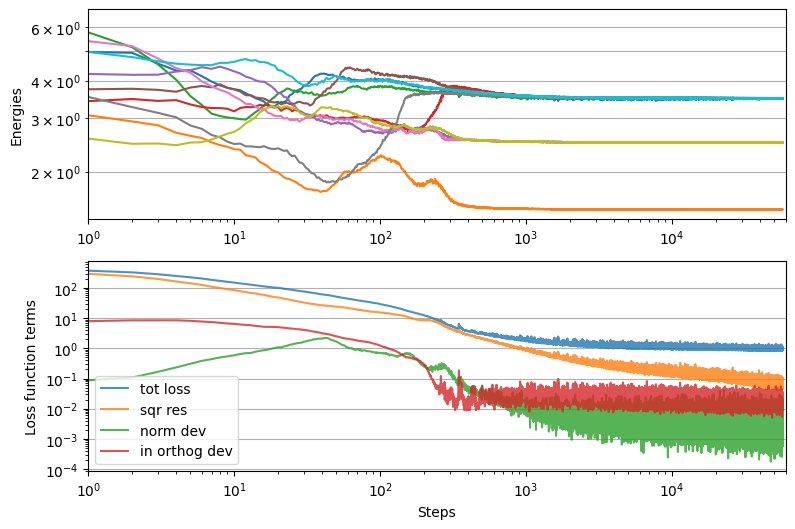

In [176]:
hist = pd.read_csv("../results/best/hist_TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11.csv")

fig, axes = plt.subplots(2, 1, figsize=(9,6))

hist[hist.columns[-10:]].plot(ax=axes[0], xlim=(1,None), legend=False)
axes[0].grid(axis='y', which='both')
axes[0].minorticks_on
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].set_ylabel("Energies")

hist[hist.columns[2:-10]].plot(ax=axes[1], xlim=(1,None), legend=True, alpha=0.8)
axes[1].grid(axis='y')
axes[1].set_yscale("log")
axes[1].set_xscale("log")
axes[1].set_ylabel("Loss function terms")
axes[1].set_xlabel("Steps")

fig.savefig("../results/best/TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_hist.png")

hist[-1:].transpose()

# TEST 2 (20 states)

In [ ]:
configTest = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 30,
        "number of hidden layers" : 7,
        "coordinate space dimension" : 3,
        "number of states" : 20,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 0.0,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 20.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        "std of initial weights" : math.sqrt(0.1)
    }

modelTest = createAndTrainModel(
    config=configTest,
    maxSqrResidual=0.001,
    trainName="TEST_09:12:2023",
    pathToSaveData="../results/",
    STEP_PERIOD=100
)

In [181]:
ls ../results/best/

MODEL_TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11.pt
MODEL_TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10.pt
OPTIMIZER_TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11.pt
OPTIMIZER_TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10.pt
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_hist.png
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_state0.png
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_state1.png
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_state2.png
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_state3.png
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_state4.png
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_state5.png
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_state6.png
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_state7.png
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_state8.png
TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11_state9.png
hist_TEST_08:12:2023_3d_30L_5Nh_08Dec2023_18:06:11.csv
hist_TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10.csv


,72599
Unnamed: 0,72599.000000
time,29864.416425
tot loss,3.201482
sqr res,0.902160
norm dev,0.018655
in orthog dev,0.090044
e0,4.527389
e1,3.490466
e2,3.504432
e3,2.495722


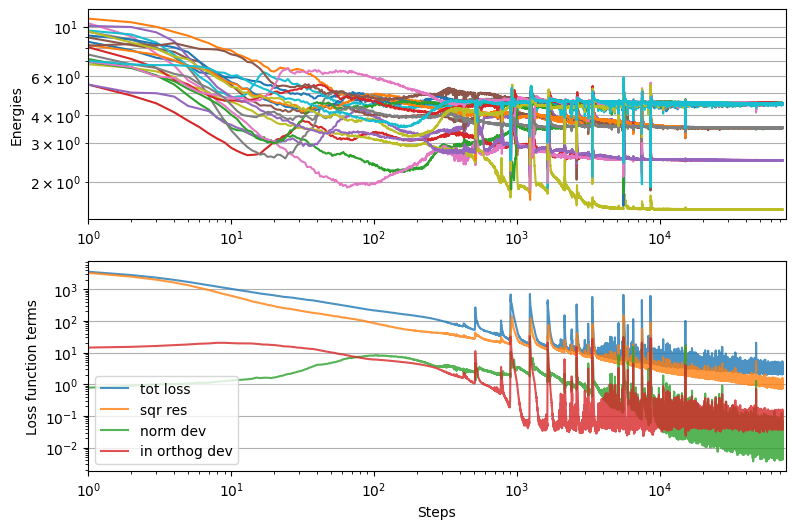

In [183]:
hist = pd.read_csv("../results/best/hist_TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10.csv")

fig, axes = plt.subplots(2, 1, figsize=(9,6))

hist[hist.columns[-20:]].plot(ax=axes[0], xlim=(1,None), legend=False)
axes[0].grid(axis='y', which='both')
axes[0].minorticks_on
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].set_ylabel("Energies")

hist[hist.columns[2:-20]].plot(ax=axes[1], xlim=(1,None), legend=True, alpha=0.8)
axes[1].grid(axis='y')
axes[1].set_yscale("log")
axes[1].set_xscale("log")
axes[1].set_ylabel("Loss function terms")
axes[1].set_xlabel("Steps")

fig.savefig("../results/best/TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10_hist.png")

hist[-1:].transpose()

In [ ]:
figs = footprintPlot(
    configTest, 
    "TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10", 
    modelPath="../results/best/MODEL_TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10.pt",
    states=np.arange(20)
)

for i, fig in enumerate(figs):
    print(i)
    fig.savefig(f"../results/best/TEST_TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10_state{i}.png")

In [191]:
model = TrialFunction(configTest, "TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10")
model.load_state_dict(torch.load("../results/best/MODEL_TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10.pt"))
model.eval()

sampler = MetropolisSampler(configTest)
for i in range(100):
    sampler.updateSampleBasOnDistrDens(model.weightFunction)

sample = sampler.sample
sqrRes = model.squeredResidual(sample)

for state in range(20):
    print(f"{sqrRes[state].cpu().detach().item():.4e}")

Trial function with name TEST_09:12:2023_3d_30L_7Nh_09Dec2023_13:06:10 has been created
6.1150e-02
2.2024e-02
2.0063e-02
1.1625e-02
2.3650e-02
2.0390e-02
1.6672e-02
1.0241e-01
1.2920e-03
1.7413e-01
5.2740e-02
2.1256e-02
6.0818e-02
5.6328e-02
1.0807e-02
7.9687e-02
6.0090e-02
1.4629e-02
5.1369e-02
6.0123e-02


# TEST 3 (40 states)

In [17]:
config_test = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 30,
        "number of hidden layers" : 10,
        "coordinate space dimension" : 3,
        "number of states" : 40,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 0.0,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 100.0,
        "energy term weight" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        "std of initial weights" : math.sqrt(0.1)
    }

model_test = trainModel(
    config=config_test,
    maxSqrResidual=1e-3,
    trainName="TEST_3_40states",
    pathToSaveData="../results/",
    STEP_PERIOD=100
)

Trial function with name TEST_3_40states_3d_30L_10Nh_20Dec2023_19:31:00 has been created
step, time, tot loss, sqr res, norm dev, in orthog dev,, e0, e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14, e15, e16, e17, e18, e19, e20, e21, e22, e23, e24, e25, e26, e27, e28, e29, e30, e31, e32, e33, e34, e35, e36, e37, e38, e39
100, 93.50, 3.89e+03, 1.03e+03, 7.36e+00, 2.86e+01,, 3.70e+00, 3.80e+00, 3.93e+00, 4.09e+00, 4.30e+00, 4.40e+00, 4.54e+00, 4.66e+00, 5.17e+00, 5.23e+00, 5.47e+00, 5.58e+00, 5.63e+00, 5.68e+00, 5.75e+00, 5.83e+00, 5.84e+00, 5.87e+00, 5.92e+00, 5.97e+00, 5.98e+00, 6.10e+00, 6.33e+00, 6.37e+00, 6.38e+00, 6.51e+00, 6.59e+00, 6.60e+00, 6.74e+00, 6.79e+00, 6.87e+00, 7.03e+00, 7.16e+00, 7.32e+00, 7.41e+00, 7.49e+00, 7.52e+00, 7.64e+00, 7.77e+00, 8.41e+00
200, 185.94, 2.60e+03, 5.79e+02, 1.41e+01, 2.01e+01,, 2.92e+00, 2.99e+00, 3.12e+00, 3.66e+00, 3.95e+00, 4.16e+00, 4.58e+00, 4.70e+00, 4.78e+00, 5.00e+00, 5.05e+00, 5.10e+00, 5.15e+00, 5.16e+00, 5.16e+00, 5.28e+00,

KeyboardInterrupt: 

In [10]:
config_test = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 30,
        "number of hidden layers" : 2,
        "coordinate space dimension" : 3,
        "number of states" : 16,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 0.0,
        "residual term weight" : 0.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weight" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        "std of initial weights" : math.sqrt(0.1)
    }

model_test = trainModel(
    config=config_test,
    maxSqrResidual=1e-3,
    trainName="TEST_4_16states",
    pathToSaveData="../results/",
    STEP_PERIOD=100
)

Trial function with name TEST_4_16states_3d_30L_2Nh_23Dec2023_17:45:39 has been created
step, time, tot loss, sqr res, norm dev, in orthog dev,, e0, e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14, e15
100, 22.87, 1.60e+02, 9.43e+01, 3.99e+00, 3.85e+00,, 1.98e+00, 2.46e+00, 2.70e+00, 2.76e+00, 2.79e+00, 3.19e+00, 3.30e+00, 4.05e+00, 4.27e+00, 4.39e+00, 4.48e+00, 5.22e+00, 5.96e+00, 6.82e+00, 6.94e+00, 8.75e+00
200, 43.91, 6.22e+01, 1.38e+02, 4.04e+00, 1.39e+00,, 2.45e+00, 2.77e+00, 2.82e+00, 2.89e+00, 3.38e+00, 4.16e+00, 4.30e+00, 4.77e+00, 4.84e+00, 5.03e+00, 5.96e+00, 6.22e+00, 6.44e+00, 7.25e+00, 8.75e+00, 9.33e+00
300, 65.31, 2.77e+01, 1.78e+02, 4.04e+00, 5.24e-01,, 2.23e+00, 2.85e+00, 2.86e+00, 4.22e+00, 4.29e+00, 4.35e+00, 4.91e+00, 5.08e+00, 5.12e+00, 6.43e+00, 6.51e+00, 6.72e+00, 7.65e+00, 8.08e+00, 9.39e+00, 1.07e+01
400, 86.12, 1.77e+01, 2.03e+02, 3.98e+00, 2.72e-01,, 2.08e+00, 2.84e+00, 2.84e+00, 4.22e+00, 4.25e+00, 4.72e+00, 4.81e+00, 4.88e+00, 6.32e+00, 6.87e+0

KeyboardInterrupt: 

,11299
Unnamed: 0,11299.000000
time,11276.844054
tot loss,269.327789
sqr res,152.324554
norm dev,58.296661
in orthog dev,0.584632
e0,3.914145
e1,10.806110
e2,8.949968
e3,9.596479


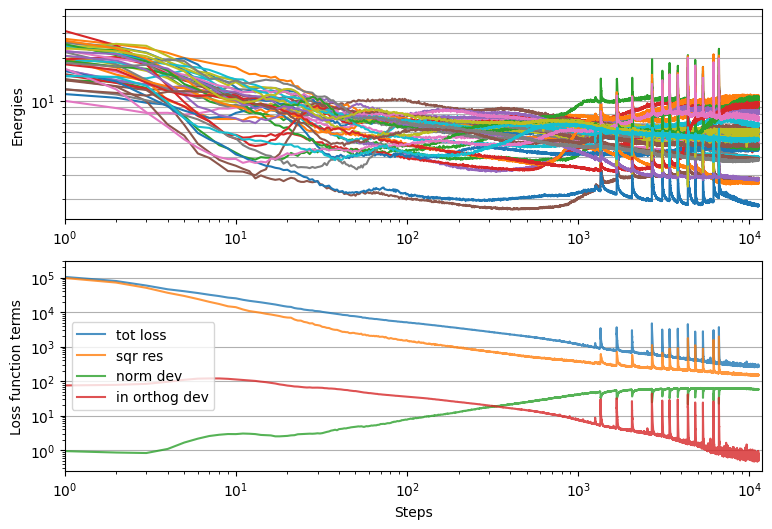

In [16]:
modelName = "TEST_11:12:2023_3d_30L_10Nh_11Dec2023_14:12:34"

hist = pd.read_csv("../results/best/hist_"+modelName+".csv")

fig, axes = plt.subplots(2, 1, figsize=(9,6))

numberOfStates = 40

hist[hist.columns[-numberOfStates:]].plot(ax=axes[0], xlim=(1,None), legend=False)
axes[0].grid(axis='y', which='both')
axes[0].minorticks_on
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].set_ylabel("Energies")

hist[hist.columns[2:-numberOfStates]].plot(ax=axes[1], xlim=(1,None), legend=True, alpha=0.8)
axes[1].grid(axis='y')
axes[1].set_yscale("log")
axes[1].set_xscale("log")
axes[1].set_ylabel("Loss function terms")
axes[1].set_xlabel("Steps")

fig.savefig("../results/best/"+modelName+"_hist.png")

hist[-1:].transpose()

In [ ]:
figs = footprintPlot(
    configTest, 
    modelName, 
    modelPath="../results/best/"+modelName+".pt",
    states=np.arange(20)
)

for i, fig in enumerate(figs):
    print(i)
    fig.savefig(f"../results/best/"+modelName+"_state{i}.png")

# My alghorithm

In [7]:
def computeNumberOfValidStates(validStates):
    res = 0
    for l1 in validStates:
        for l2 in l1:
            res += 1
    return res

In [66]:
def changeNNShape(theConfig: dict, numberOfValidStates: int):
    # if (numberOfValidStates < 1):
    #     theConfig["hidden layer size"] = 20
    #     theConfig["number of hidden layers"] = 1
    # elif (numberOfValidStates < 4):
    #     theConfig["hidden layer size"] = 60
    #     theConfig["number of hidden layers"] = 2
    # else:
    theConfig["hidden layer size"] = 60
    theConfig["number of hidden layers"] = max(1,numberOfValidStates//2)

In [109]:
def calcExOrthogDev(
    theModel,
    models: list,
    validStatesForEachModel: list,
    config: dict
) -> torch.Tensor:
    exOrthogDev = torch.tensor(0.0).to(theModel.device)

    s = MetropolisSampler(config)

    for modelNumber, model in enumerate(models):
        for validState in validStatesForEachModel[modelNumber]:
            for theState in range(theModel.neuralNetwork.numberOfStates):
                wf = lambda x: 0.5 * (
                    model(x)[:,validState]**2 / torch.sum(model(x)[:,validState]**2) 
                    + theModel(x)[:,theState]**2 / torch.sum(theModel(x)[:,theState]**2) 
                )
                for i in range(10):
                    s.updateSampleBasOnDistrDens(wf)
                sample = s.sample
                _wf = wf(sample)
                exOrthogDev_ = (
                    torch.square(
                        torch.mean(
                            theModel(sample)[:,theState] * model(sample)[:,validState]
                            / _wf
                        )
                    )
                    / torch.mean(theModel(sample)[:,theState]**2 / _wf)
                    / torch.mean(model(sample)[:,validState]**2 / _wf)
                    # / theNorm[theState] / norm[validState]
                )
                exOrthogDev += exOrthogDev_ #/ factor
    return exOrthogDev

In [110]:
def detValidStates(
    model, 
    sample,
    maxSqrResidual
) -> list:
    sqrResidual = torch.tensor(model.squeredResidual(sample))
    return torch.where(sqrResidual < maxSqrResidual)[0].tolist()

In [116]:
def createAndTrainModel(
    config: dict,
    models: list,
    validStatesForEachModel: list,
    maxSqrResidual: float,
    trainName: str,
    pathToSaveData: str,
    STEP_PERIOD=100
):
    time0 = time.time()
    hist = {
        'time' : list(),
        'tot loss' : list(),
        'sqr res' : list(),
        'norm dev' : list(),
        'in orthog dev' : list(),
        'ex orthog dev' : list(),
    }
    for i in range(config['number of states']):
        hist[f"e{i}"] = list()
    
    modelName = trainName + "_" + str(
        f"{config['coordinate space dimension']}d_"
        +f"{config['hidden layer size']}L_"
        +f"{config['number of hidden layers']}Nh_"
        +time.strftime("%d%b%Y_%H:%M:%S", time.gmtime())
    )
    model = TrialFunction(config, modelName)

    optimizer = torch.optim.AdamW(
        params=list(model.parameters()),
        lr=config['initial learning rate'],
        weight_decay=config['weight decay'],
    )

    validStates = []

    lossFnc = nn.L1Loss()
    
    step = 0
    goodSteps = 0
    while goodSteps < 100:
        if step == 0:
            sampler = MetropolisSampler(config)
        else:
            for i in range(10):
                sampler.updateSampleBasOnDistrDens(
                    model.weightFunction
                )
        step += 1
        # Loss
        sample = sampler.sample
        sqrRes = model.totalSqueredResidual(sample)
        normDev = model.totalNormalisationError(sample)
        e = model.spectrum(sample)
        inOrthogDev = model.totalOrthogonalisationError(sample)
        exOrthogDev = calcExOrthogDev(model, models, validStatesForEachModel, config)
        # eFactor = float(torch.sum(e).detach().item())
        # inOrthogDevFactor = float(inOrthogDev.detach().item())
        # exOrthogDevFactor = float(exOrthogDev.detach().item())
        totLoss = lossFnc(
            config['residual term weight'] * sqrRes 
            + config['normalisation term weight'] * normDev
            + torch.sum(e) #/ eFactor 
            + config['orthogonalisation term weight'] * inOrthogDev
            + config['orthogonalisation term weight'] * exOrthogDev,
            torch.tensor(0.0).to(config['device'])
        )
        # Backpropagation
        optimizer.zero_grad()
        totLoss.backward()
        optimizer.step()

        # if sqrRes.item() < maxSqrResidual:
        #     goodSteps += 1
        # else:
        #     goodSteps = 0
        
        validStates = detValidStates(model, sample, maxSqrResidual)
        if len(validStates) > 0:
            goodSteps += 1
        else:
            goodSteps = 0
        
        # History
        hist['time'] += [time.time() - time0]
        hist['tot loss'] += [totLoss.item()]
        hist['sqr res'] += [sqrRes.item()]
        hist['norm dev'] += [normDev.item()]
        hist['in orthog dev'] += [inOrthogDev.item()]
        hist['ex orthog dev'] += [exOrthogDev.item()]
        for i in range(config['number of states']):
            hist[f"e{i}"] += [e[i].item()]
        if step == 1:
                header = (
                    "step, time, tot loss, sqr res,"
                    + " norm dev, in orthog dev, ex orthog dev"
                )
                for i in range(config['number of states']):
                    header += f", e{i}"
                print(header)
        if (step % STEP_PERIOD) == 0:
            info = (
                f"{step}, "
                + f"{time.time() - time0:.2f}, "
                + f"{totLoss.item():.2e}, "
                + f"{sqrRes.item():.2e}, "
                + f"{normDev.item():.2e}, "
                + f"{inOrthogDev.item():.2e}, "
                + f"{exOrthogDev.item():.2e}"
            )
            for e_ in torch.sort(e)[0]:
                info += f", {e_.item():.2e}"
            # for i in range(config['number of states']):
            #     info += f", {e[i]:.2e}"
            print(info)
            torch.save(model.state_dict(), pathToSaveData + "MODEL_" + model.name + ".pt")
            torch.save(optimizer.state_dict(), pathToSaveData + "OPTIMIZER_" + model.name + ".pt")
            hist_df = pd.DataFrame(data=hist)
            hist_df.to_csv(pathToSaveData + f"hist_{model.name}.csv")
    
    return model, validStates

In [117]:
# config0 = {
#         "device" : "cuda" if torch.cuda.is_available() else "cpu",
#         "activation function" : "sin",
#         "amplitude function" : "gaussian",
#         "hidden layer size" : 20,
#         "number of hidden layers" : 10,
#         "coordinate space dimension" : 3,
#         "number of states" : 35,
#         "sample size" : 8192,
#         "initial learning rate" : 1e-3,
#         "weight decay" : 1e-3,
#         "residual term weight" : 1.0,
#         "normalisation term weight" : 1.0,
#         "orthogonalisation term weight" : 40.0,
#         "energy term weigth" : 1.0,
#         "metropolis algorithm parameter" : 1.0,
#         "number of training steps" : 15000,
#         "std of initial weights" : math.sqrt(0.1)
#     }

# models0, validStatesForEachModel0 = createAndTrainModel(
#     config=config0,
#     models=[],
#     validStatesForEachModel=[],
#     maxSqrResidual=0.01,
#     trainName="test0",
#     pathToSaveData="../results/"
# )

In [118]:
def generalTraining(
    wishedNumberOfStates: int, 
    maxSqrResidual: float,
    initConfig: dict,
    trainName: str,
    pathToSaveData: str,
    models = [],
    validStatesForEachModel = [],
    STEP_PERIOD=100
):
    numberOfValidStates = computeNumberOfValidStates(validStatesForEachModel)
    
    time0 = time.time()
    
    while (numberOfValidStates < wishedNumberOfStates):
        # Info
        print(f"We compute {numberOfValidStates:} valid states")        
        # Set the current configuration
        theConfig = copy.deepcopy(initConfig)
        changeNNShape(theConfig, numberOfValidStates)
        
        theModel, theValidStates = createAndTrainModel(
            theConfig, models, validStatesForEachModel, maxSqrResidual, 
            trainName, pathToSaveData,STEP_PERIOD
        )
        
        models += [theModel]
        validStatesForEachModel += [theValidStates]
        # Update number of valid states
        numberOfValidStates = computeNumberOfValidStates(validStatesForEachModel)
    
    return models, validStatesForEachModel

# Find 10 states

## Restore previous results

In [119]:
config1 = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 30,
        "number of hidden layers" : 2,
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        "std of initial weights" : math.sqrt(0.1)
    }
model1 = TrialFunction(
    config1,
    "test0_3d_30L_2Nh_05Dec2023_14:37:14"
)
model1.load_state_dict(torch.load("../results/MODEL_test0_3d_30L_2Nh_05Dec2023_14:37:14.pt"))
model1.eval()

sampler1 = MetropolisSampler(config1)
for i in range(10):
    sampler1.updateSampleBasOnDistrDens(model1.weightFunction)

validStatesForModel1 = detValidStates(model1,sampler1.sample,0.001)

config2 = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 60,
        "number of hidden layers" : 2,
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        "std of initial weights" : math.sqrt(0.1)
    }
model2 = TrialFunction(
    config2,
    "test0_3d_60L_2Nh_05Dec2023_21:49:28"
)
model2.load_state_dict(torch.load("../results/MODEL_test0_3d_60L_2Nh_05Dec2023_21:49:28.pt"))
model2.eval()

sampler2 = MetropolisSampler(config2)
for i in range(10):
    sampler2.updateSampleBasOnDistrDens(model2.weightFunction)

validStatesForModel2 = detValidStates(model2,sampler2.sample,0.005)

model3 = TrialFunction(
    config2,
    "test0_3d_60L_2Nh_05Dec2023_22:18:11"
)
model3.load_state_dict(torch.load("../results/MODEL_test0_3d_60L_2Nh_05Dec2023_22:18:11.pt"))
model3.eval()

sampler3 = MetropolisSampler(config2)
for i in range(10):
    sampler3.updateSampleBasOnDistrDens(model3.weightFunction)

validStatesForModel3 = detValidStates(model3,sampler3.sample,0.005)

Trial function with name test0_3d_30L_2Nh_05Dec2023_14:37:14 has been created
Trial function with name test0_3d_60L_2Nh_05Dec2023_21:49:28 has been created
Trial function with name test0_3d_60L_2Nh_05Dec2023_22:18:11 has been created


## General training

In [120]:
initConfig = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 20,
        "number of hidden layers" : 1,
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        "std of initial weights" : math.sqrt(0.1)
    }

models, validStatesForEachModel = generalTraining(
    wishedNumberOfStates=10,
    maxSqrResidual=0.005,
    initConfig=initConfig,
    trainName="test0",
    pathToSaveData="../results/",
    models=[model1, model2, model3],
    validStatesForEachModel=[validStatesForModel1, validStatesForModel2, validStatesForModel3],
    STEP_PERIOD=1
)

We compute 4 valid states
Trial function with name test0_3d_60L_2Nh_07Dec2023_07:17:00 has been created
step, time, tot loss, sqr res, norm dev, in orthog dev, ex orthog dev, e0, e1, e2, e3, e4
1, 4.34, 1.88e+02, 5.06e+01, 6.23e-02, 7.00e-01, 2.30e+00, 2.40e+00, 2.90e+00, 2.99e+00, 3.32e+00, 5.99e+00
2, 8.70, 1.90e+02, 4.85e+01, 6.57e-02, 8.22e-01, 2.23e+00, 2.41e+00, 2.96e+00, 3.25e+00, 3.50e+00, 7.67e+00
3, 12.98, 1.84e+02, 4.88e+01, 6.55e-02, 6.91e-01, 2.16e+00, 2.42e+00, 3.01e+00, 3.38e+00, 3.60e+00, 8.09e+00
4, 17.32, 1.74e+02, 4.75e+01, 5.35e-02, 5.51e-01, 2.07e+00, 2.54e+00, 3.03e+00, 3.52e+00, 3.66e+00, 8.29e+00
5, 21.58, 1.67e+02, 4.82e+01, 3.67e-02, 4.37e-01, 1.99e+00, 2.71e+00, 3.16e+00, 3.58e+00, 3.71e+00, 8.21e+00
6, 25.92, 1.58e+02, 4.80e+01, 2.34e-02, 3.54e-01, 1.85e+00, 2.94e+00, 3.19e+00, 3.68e+00, 3.75e+00, 8.12e+00
7, 30.26, 1.50e+02, 4.72e+01, 2.26e-02, 3.06e-01, 1.73e+00, 3.18e+00, 3.26e+00, 3.69e+00, 3.85e+00, 7.95e+00
8, 34.60, 1.40e+02, 4.56e+01, 2.06e-02, 2.35e

KeyboardInterrupt: 

In [18]:
ls ../results

MODEL_test0_3d_30L_2Nh_05Dec2023_14:37:14.pt
OPTIMIZER_test0_3d_30L_2Nh_05Dec2023_14:37:14.pt
hist_test0_3d_30L_2Nh_05Dec2023_14:37:14.csv


In [21]:
trialFunction_3D = TrialFunction(
    {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 30,
        "number of hidden layers" : 2,
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        "std of initial weights" : math.sqrt(0.1)
    },
    "test0_3d_30L_2Nh_05Dec2023_14:37:14"
)
trialFunction_3D.load_state_dict(torch.load("../results/MODEL_test0_3d_30L_2Nh_05Dec2023_14:37:14.pt"))
trialFunction_3D.eval()

Trial function with name test0_3d_30L_2Nh_05Dec2023_14:37:14 has been created


TrialFunction(
  (neuralNetwork): NeuralNetwork(
    (activationFunction): CustomSin()
    (stack): Sequential(
      (0): Linear(in_features=3, out_features=30, bias=True)
      (1): CustomSin()
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): CustomSin()
      (4): Linear(in_features=30, out_features=5, bias=True)
      (5): CustomSin()
    )
  )
  (amplitudeFunction): Gaussian()
)

0
1
2


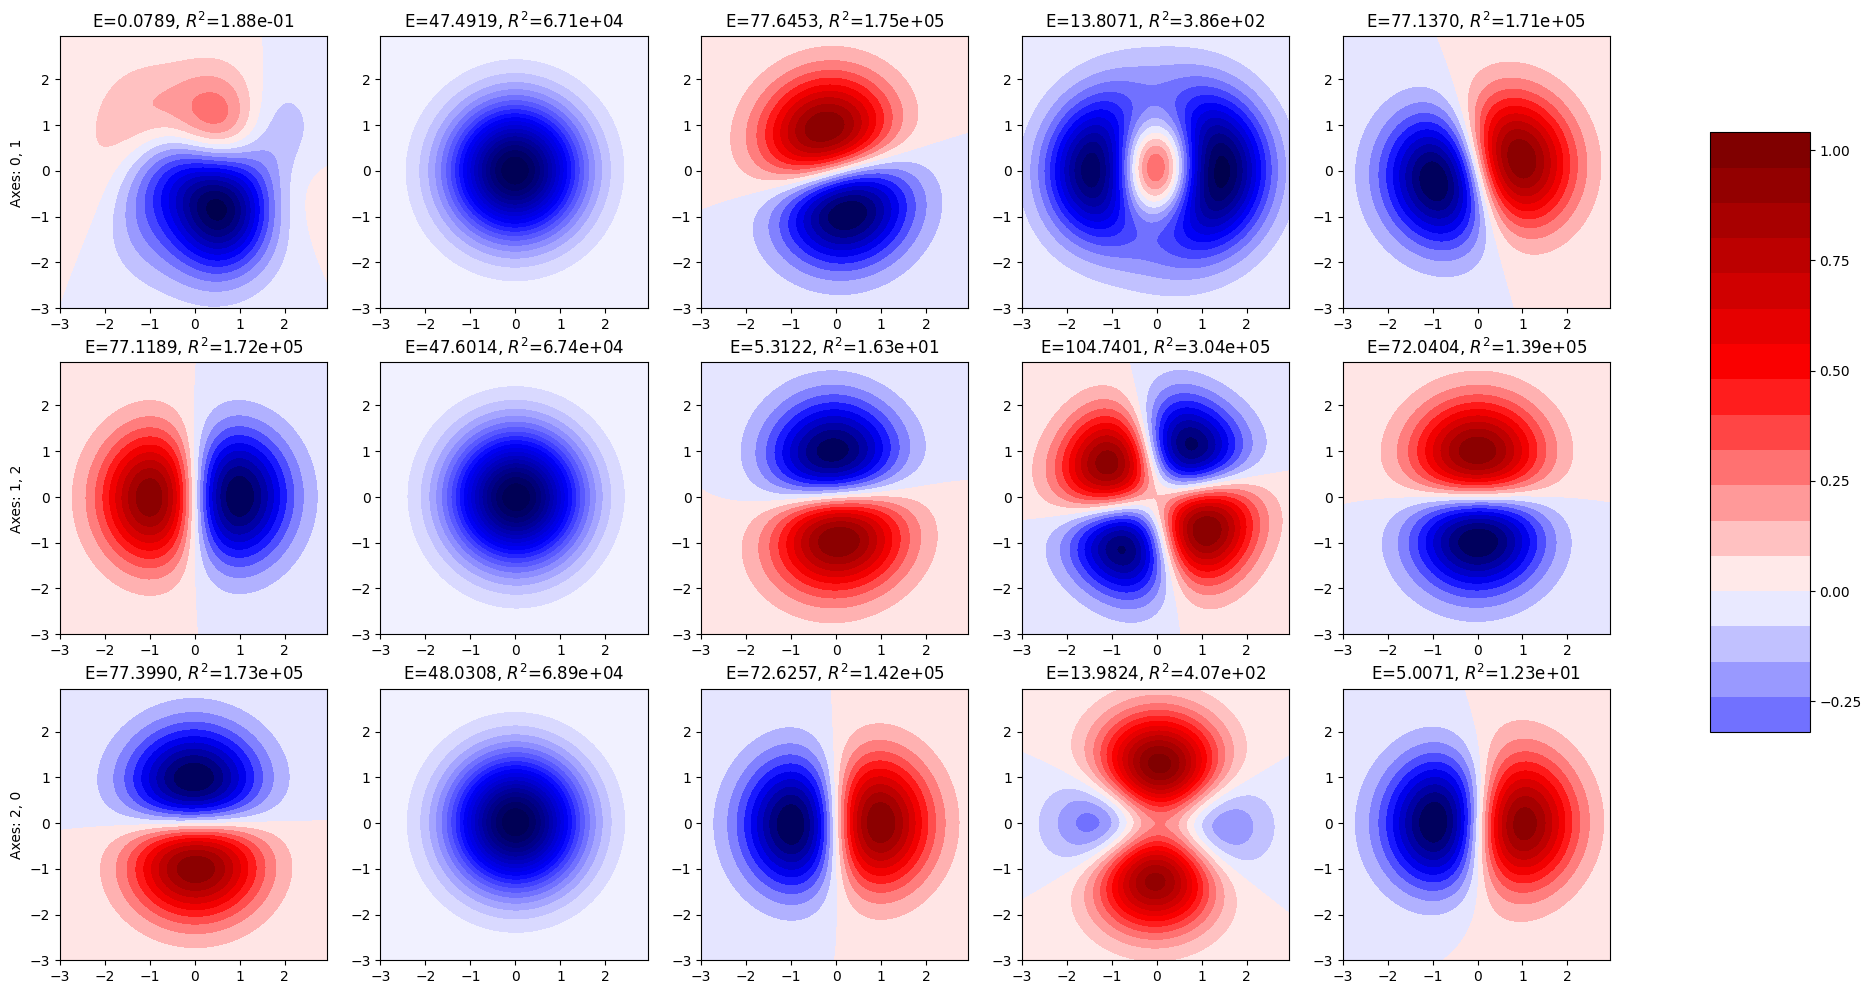

In [22]:
D = 3
fig, axes = plt.subplots(
    D,5,
    figsize=(4*5,D*4),
    squeeze=False
)
for axNumber in range(D):
    print(axNumber)
    grid = torch.zeros(
        (10000,D),
        device="cuda"
    )
    for ix in range(100):
        for iy in range(100):
            grid[ix*100+iy,axNumber%D] = -3 + 6 * ix / 100
            grid[ix*100+iy,(axNumber+1)%D] = -3 + 6 * iy / 100
    e = trialFunction_3D.spectrum(grid, False)
    r2 = trialFunction_3D.squeredResidual(grid, False)
    wf = trialFunction_3D(grid)
    for i in range(5):
        if i != 4:
            pcmesh = axes[axNumber,i].contourf(
            -3 + 6 * np.arange(100) / 100,
            -3 + 6 * np.arange(100) / 100, 
            (wf[:,i] / torch.max(torch.abs(wf[:,i]))).cpu().detach().numpy().reshape(100,100),
            cmap='seismic',
            vmin=-1, vmax=1,
            levels=20
            )
        else:
            axes[axNumber,i].contourf(
            -3 + 6 * np.arange(100) / 100,
            -3 + 6 * np.arange(100) / 100, 
            (wf[:,i] / torch.max(torch.abs(wf[:,i]))).cpu().detach().numpy().reshape(100,100),
            cmap='seismic',
            vmin=-1, vmax=1,
            levels=20
            )
        axes[axNumber,i].set_title(fr'E={e[i]:.4f}, $R^2$={r2[i]:.2e}')
    axes[axNumber,0].set_ylabel(f"Axes: {axNumber%D}, {(axNumber+1)%D}")
    # ax.set_title()
    # axes.legend()
    # ax.set_xlim(-3,3)
    # ax.set_ylim(0,None)
    # axes.grid()
# fig.adjust_subplots(hspace=0.2)
cax = plt.axes((0.95, 0.3, 0.05, 0.5))
fig.colorbar(pcmesh, cax=cax, orientation='vertical', ticks=np.arange(-1,1+0.1,0.25))